In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

2024-06-21 15:21:00.244502: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 15:21:00.940707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Set up data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [3]:
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    model = models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return model

input_shape = x_train.shape[1:]
latent_dim = 2
encoder = build_encoder(input_shape, latent_dim)
encoder.summary()

2024-06-21 15:21:02.494146: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 420,868 (1.61 MB)

 Trainable params: 420,868 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    model = models.Model(latent_inputs, outputs, name='decoder')
    return model

decoder = build_decoder(latent_dim)
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def build_discriminator(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs, name='discriminator')
    return model

discriminator = build_discriminator(x_train.shape[1:])
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,481 (1.60 MB)

 Trainable params: 420,481 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
def triplet_loss(anchor, positive, negative, alpha=0.2):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    return tf.maximum(pos_dist - neg_dist + alpha, 0.0)

In [7]:
class VAE_GAN(tf.keras.Model):
    def __init__(self, encoder, decoder, discriminator, **kwargs):
        super(VAE_GAN, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator
        self.latent_dim = encoder.output[0].shape[-1]

    def compile(self, encoder_optimizer, decoder_optimizer, discriminator_optimizer, loss_fn):
        super(VAE_GAN, self).compile()
        self.encoder_optimizer = encoder_optimizer
        self.decoder_optimizer = decoder_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        x_real = data

        batch_size = tf.shape(x_real)[0]
        random_latent_vectors = tf.keras.backend.random_normal(shape=(batch_size, self.latent_dim))

        # Compute gradients for VAE loss
        with tf.GradientTape() as tape_vae:
            z_mean, z_log_var, z = self.encoder(x_real)
            x_fake = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x_real, x_fake))
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            vae_loss = reconstruction_loss + kl_loss

        # Compute gradients for discriminator loss
        with tf.GradientTape() as tape_discriminator:
            z_mean, z_log_var, z = self.encoder(x_real)
            x_fake = self.decoder(z)
            real_output = self.discriminator(x_real)
            fake_output = self.discriminator(x_fake)

            discriminator_loss = self.loss_fn(tf.ones_like(real_output), real_output) + \
                                 self.loss_fn(tf.zeros_like(fake_output), fake_output)

        # Apply gradients for VAE and discriminator separately
        grads_vae = tape_vae.gradient(vae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.encoder_optimizer.apply_gradients(zip(grads_vae, self.encoder.trainable_variables + self.decoder.trainable_variables))

        grads_discriminator = tape_discriminator.gradient(discriminator_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(grads_discriminator, self.discriminator.trainable_variables))

        return { "vae_loss": vae_loss, "discriminator_loss": discriminator_loss }

In [8]:
# Visualize the results
def plot_generated_images(model, num_images=10):
    random_latent_vectors = tf.keras.backend.random_normal(shape=(num_images, latent_dim))
    generated_images = model.decoder(random_latent_vectors)
    generated_images = generated_images.numpy().reshape((num_images, 28, 28))

    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.show()

Epoch 1/20


2024-06-21 15:21:02.723186: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


938/938 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - discriminator_loss: 0.0567 - vae_loss: 0.3352
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - discriminator_loss: 3.8924e-04 - vae_loss: 0.2667
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - discriminator_loss: 1.3896e-04 - vae_loss: 0.2644
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - discriminator_loss: 2.5667e-05 - vae_loss: 0.2637
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - discriminator_loss: 1.1680e-05 - vae_loss: 0.2634
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - discriminator_loss: 8.6033e-06 - vae_loss: 0.2632
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - discriminator_loss: 6.8844e-06 - vae_loss: 0.2631
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - discriminator_loss: 2.0058e-06 - vae_loss: 0.2631
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - discriminator_loss: 1.2997e-06 - vae_loss: 0.2630
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - disc

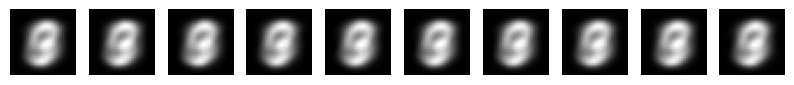

/home/choconao/Documents/Programming/Python/ml-hometask/.venv/lib/python3.12/site-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


In [9]:
# Compile and train the model
vae_gan = VAE_GAN(encoder, decoder, discriminator)
vae_gan.compile(
    encoder_optimizer=optimizers.Adam(learning_rate=1e-4),
    decoder_optimizer=optimizers.Adam(learning_rate=1e-4),
    discriminator_optimizer=optimizers.Adam(learning_rate=1e-4),
    loss_fn=losses.BinaryCrossentropy()
)

vae_gan.fit(x_train, epochs=20, batch_size=64)

# Visualize the results
plot_generated_images(vae_gan)

# Save the model
vae_gan.save('./output/vaegan/vaegan.keras')